In [1]:
from pathlib import Path
import re
import numpy as np
import pandas as pd
import rasterio
from skimage.filters import threshold_otsu

# ====== RUTAS (CAMBIA SOLO ESTA FECHA/CARPETA) ======
image_directory = Path(r"E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\plots_stack_20251210")
out_dir = image_directory.parent / "endmembers_20251210"
out_dir.mkdir(parents=True, exist_ok=True)

# ====== BANDAS ======
band_names = ['B', 'G', 'R', 'RE', 'NIR']
NIR_IDX = 4  # 0:B,1:G,2:R,3:RE,4:NIR

# ====== PUREZA (ajusta si quieres) ======
VEG_TOP_PCT = 98   # top 2% NIR dentro de veg
SOIL_BOT_PCT = 30  # bottom 30% NIR dentro de soil
MIN_PIXELS = 20    # mínimo pixeles puros aceptables

def ensure_reflectance(arr: np.ndarray) -> np.ndarray:
    """Si viene 0..10000 -> 0..1. Si ya está 0..1 no cambia."""
    arr = arr.astype(np.float32)
    mx = np.nanmax(arr)
    if mx > 1.5:
        arr = arr / 10000.0
    return arr

def get_plot_id(filename: str) -> int:
    m = re.search(r"plot_(\d+)_stack\.tif$", filename)
    return int(m.group(1)) if m else None

def mean_endmember(img5: np.ndarray, mask: np.ndarray) -> np.ndarray:
    """img5: (5,H,W), mask:(H,W) -> (5,) o NaNs"""
    if mask.sum() < MIN_PIXELS:
        return np.array([np.nan]*5, dtype=np.float32)
    vals = img5[:, mask].T  # (n,5)
    return np.nanmean(vals, axis=0).astype(np.float32)

print("image_directory:", image_directory)
print("out_dir:", out_dir)


image_directory: E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\plots_stack_20251210
out_dir: E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\endmembers_20251210


Otsu t: 0.3028610646724701
veg pixels: 15859 pure veg: 319
soil pixels: 32611 pure soil: 9784


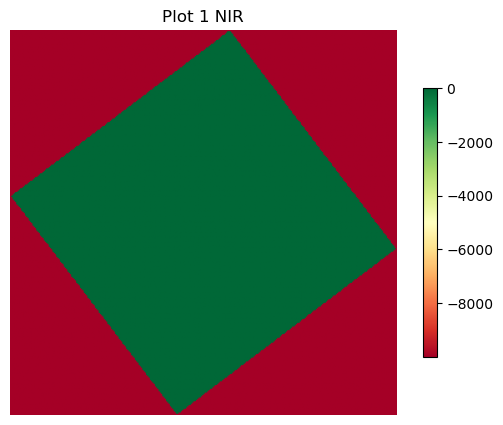

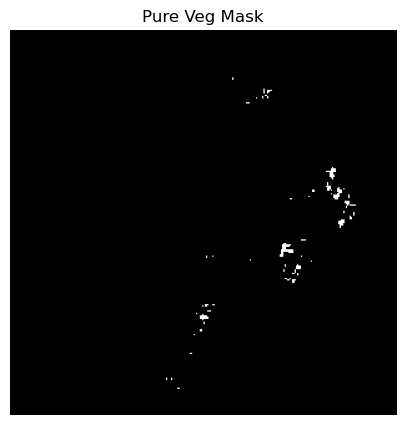

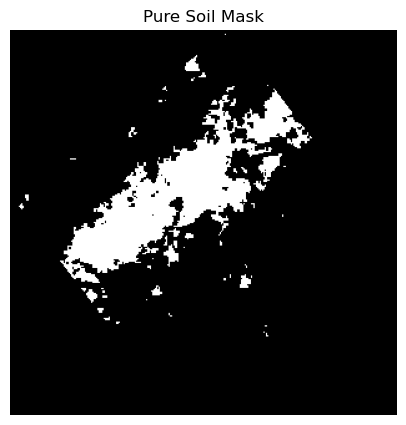

In [2]:
import matplotlib.pyplot as plt

test_plot_id = 1
test_path = image_directory / f"plot_{test_plot_id}_stack.tif"

with rasterio.open(test_path) as src:
    img = ensure_reflectance(src.read())
nir = img[NIR_IDX]
valid = np.isfinite(nir) & (nir > 0)

t = threshold_otsu(nir[valid]) if valid.sum() > 50 else np.nanmedian(nir[valid])
veg_mask = valid & (nir > t)
soil_mask = valid & (nir <= t)

# percentiles para "pure"
veg_thr = np.nanpercentile(nir[veg_mask], VEG_TOP_PCT) if veg_mask.sum() > 50 else t
soil_thr = np.nanpercentile(nir[soil_mask], SOIL_BOT_PCT) if soil_mask.sum() > 50 else t

pure_veg = veg_mask & (nir >= veg_thr)
pure_soil = soil_mask & (nir <= soil_thr)

print("Otsu t:", float(t))
print("veg pixels:", int(veg_mask.sum()), "pure veg:", int(pure_veg.sum()))
print("soil pixels:", int(soil_mask.sum()), "pure soil:", int(pure_soil.sum()))

plt.figure(figsize=(7,5))
plt.imshow(nir, cmap="RdYlGn"); plt.colorbar(shrink=0.7)
plt.title(f"Plot {test_plot_id} NIR")
plt.axis("off"); plt.show()

plt.figure(figsize=(7,5))
plt.imshow(pure_veg, cmap="gray"); plt.title("Pure Veg Mask"); plt.axis("off"); plt.show()

plt.figure(figsize=(7,5))
plt.imshow(pure_soil, cmap="gray"); plt.title("Pure Soil Mask"); plt.axis("off"); plt.show()


In [3]:
tifs = sorted(image_directory.glob("plot_*_stack.tif"))
if len(tifs) == 0:
    raise FileNotFoundError(f"No encontré 'plot_*_stack.tif' en {image_directory}")

rows_veg, rows_soil = [], []
nan_veg, nan_soil = 0, 0

for tif in tifs:
    pid = get_plot_id(tif.name)

    with rasterio.open(tif) as src:
        img = ensure_reflectance(src.read())  # (5,H,W)

    nir = img[NIR_IDX]
    valid = np.isfinite(nir) & (nir > 0)

    if valid.sum() < 50:
        veg_end = np.array([np.nan]*5, dtype=np.float32)
        soil_end = np.array([np.nan]*5, dtype=np.float32)
    else:
        t = threshold_otsu(nir[valid])

        veg_mask = valid & (nir > t)
        soil_mask = valid & (nir <= t)

        # pure veg: top percentile
        if veg_mask.sum() > 50:
            veg_thr = np.nanpercentile(nir[veg_mask], VEG_TOP_PCT)
            pure_veg = veg_mask & (nir >= veg_thr)
        else:
            pure_veg = veg_mask

        # pure soil: bottom percentile
        if soil_mask.sum() > 50:
            soil_thr = np.nanpercentile(nir[soil_mask], SOIL_BOT_PCT)
            pure_soil = soil_mask & (nir <= soil_thr)
        else:
            pure_soil = soil_mask

        veg_end = mean_endmember(img, pure_veg)
        soil_end = mean_endmember(img, pure_soil)

    if np.isnan(veg_end).any(): nan_veg += 1
    if np.isnan(soil_end).any(): nan_soil += 1

    rows_veg.append([f"plot_{pid}_stack", *veg_end.tolist()])
    rows_soil.append([f"plot_{pid}_stack", *soil_end.tolist()])

veg_df = pd.DataFrame(rows_veg, columns=["Bands"] + band_names)
soil_df = pd.DataFrame(rows_soil, columns=["Bands"] + band_names)

veg_path = out_dir / "average_veg_values.csv"
soil_path = out_dir / "average_soil_values.csv"
veg_df.to_csv(veg_path, index=False)
soil_df.to_csv(soil_path, index=False)

print("✅ CSVs guardados:")
print("Veg:", veg_path)
print("Soil:", soil_path)
print("Plots con NaN veg:", nan_veg, "| NaN soil:", nan_soil, "| Total:", len(tifs))


✅ CSVs guardados:
Veg: E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\endmembers_20251210\average_veg_values.csv
Soil: E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\endmembers_20251210\average_soil_values.csv
Plots con NaN veg: 0 | NaN soil: 0 | Total: 202
